# load package and data

In [26]:
import google.datalab.storage as storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from google.datalab import Context
import random, string

p = sns.color_palette()

In [27]:
shared_bucket = storage.Bucket('capstone-01')
for obj in shared_bucket.objects():
  if obj.key.find('/') < 0:
    print(obj.key) # Bucket 내에 포함된 데이터 셋 확인

clicks_test.csv
clicks_train.csv
dis_ad_ctr.csv
dis_several_ads.csv
documents_categories.csv
documents_entities.csv
documents_meta.csv
documents_topics.csv
events.csv
page_views_sample.csv
promoted_content.csv
sample_submission.csv


# clicks_train & clicks_test

## load data

In [28]:
my_bucket = storage.Bucket('capstone-01')

clicks_test = my_bucket.object('clicks_test.csv')
uri = clicks_test.uri
%gcs read --object $uri --variable c_test
clicks_test = pd.read_csv(BytesIO(c_test))
clicks_test.head(5)

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888


In [29]:
clicks_train = my_bucket.object('clicks_train.csv')
uri = clicks_train.uri
%gcs read --object $uri --variable c_test
clicks_train = pd.read_csv(BytesIO(c_test))
clicks_train.head(5)

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


## shape

In [7]:
# 파일의 행렬 개수 확인
print(clicks_train.shape)
print(clicks_test.shape)
# print(train_events.shape)

(87141731, 3)
(32225162, 2)


## colnames

In [17]:
# 파일의 열 명 확인
train_col = clicks_train.columns.tolist()
test_col = clicks_test.columns.tolist()
print(train_col)
print(test_col)

# train set은 test set의 몇 배? 3.7배
print(len(clicks_test)/len(clicks_train))

['display_id', 'ad_id', 'clicked']
['display_id', 'ad_id']
0.369801719913046


## unique

In [70]:
# check the unique data of each col
# print(len(clicks_train["display_id"].unique()))
# print(len(clicks_train["ad_id"].unique()))
# print(len(clicks_test["display_id"].unique()))
# print(len(clicks_test["ad_id"].unique()))
# print((clicks_train["clicked"].sum())/len(clicks_train))

e=16874593/87141731 # train에서 unique display_id의 비율
f=478950/87141731 # train에서 unique ad_id의 비율
g=6245533/32225162 # test에서 unique display_id의 비율
h=381385/32225162 # test에서 unique ad_id의 비율
print('proportion of unique display_id in train:', round(e*100,2), '%')
print('proportion of unique ad_id in train:', round(f*100,2), '%')
print('proportion of unique display_id in test:', round(g*100,2), '%')
print('proportion of unique ad_id in test:', round(h*100,2), '%')

proportion of unique display_id in train: 19.36 %
proportion of unique ad_id in train: 0.55 %
proportion of unique display_id in test: 19.38 %
proportion of unique ad_id in test: 1.18 %


## num of ads

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Proportion of set')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


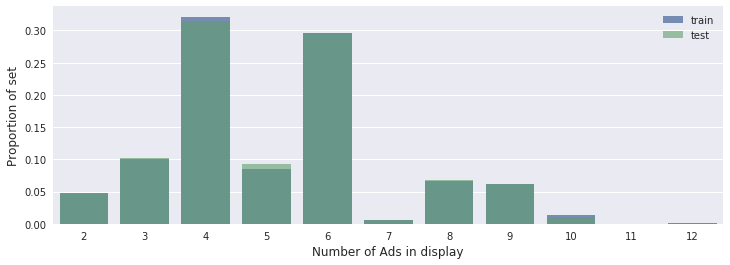

In [26]:
# 디스플레이 별 광고 개수가 몇 개일까?
# train과 test 각각 디스플레이 별 광고 개수의 분포가 비슷할까?
size_train = clicks_train.groupby('display_id')['ad_id'].count().value_counts()
size_test = clicks_test.groupby('display_id')['ad_id'].count().value_counts()
size_train = size_train / np.sum(size_train)
size_test = size_test / np.sum(size_test)

# plotting
plt.figure(figsize=(12,4))
sns.barplot(size_train.index, size_train.values, alpha=0.8, color=p[0], label='train')
sns.barplot(size_test.index, size_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('Number of Ads in display', fontsize=12)
plt.ylabel('Proportion of set', fontsize=12)

## same ads in train and test

In [69]:
# test에 있는 ad_id가 train에도 있을까? 있다면 몇 퍼센트일까?
ad_prop = len(set(clicks_test.ad_id.unique()).intersection(clicks_train.ad_id.unique())) / len(clicks_test.ad_id.unique())
print('Proportion of test ads in test that are in train set: {}%'.format(round(ad_prop *100, 2)))

Proportion of test ads in test that are in train set: 82.87%


## ad frequency

ad_id
1        2
2       22
3      161
4       32
5        1
6        1
7     3406
8       28
9        3
10      81
Name: ad_id, dtype: int64
Ads that appear less than 2 times: 22.69%
Ads that appear less than 5 times: 46.55%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


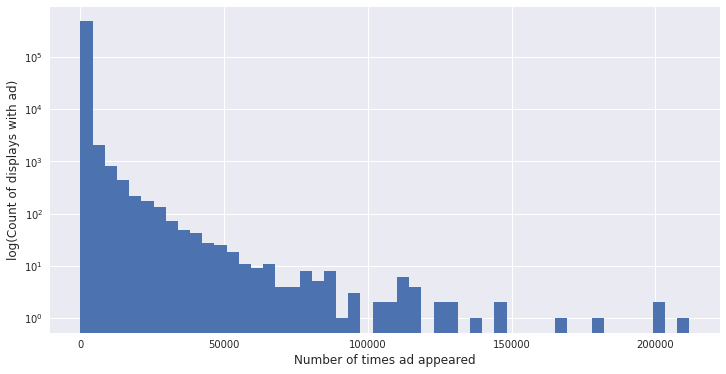

In [6]:
# train에서 고유 ad_id가 디스플레이에 노출된 빈도 수의 분포는?
ad_usage_train = clicks_train.groupby('ad_id')['ad_id'].count()
print(ad_usage_train.head(10))
for i in [2, 5, 10, 50, 100, 1000]:
    print('Ads that appear less than {} times: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2)))

# plotting
plt.figure(figsize=(12,6))
plt.hist(ad_usage_train.values, bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

In [25]:
# train set에 있는 ad_id를 count해서 내림차순으로 정렬
ad_usage_train_desc = ad_usage_train.sort_values(ascending=False)
print(ad_usage_train_desc.head(10))

ad_id
173005    211824
180923    203159
123742    202099
151028    181319
173006    168139
347688    147877
138353    144467
130952    135789
288396    128607
173403    128030
Name: ad_id, dtype: int64


In [78]:
# train에서 고유 ad_id가 디스플레이에 노출된 빈도 수의 평균과 중앙값은?
print(ad_usage_train.mean())
print(ad_usage_train.median())

181.9432738281658
5.0


In [83]:
# train에서 고유 ad_id가 디스플레이에 노출된 빈도 수
print(ad_usage_train.head())
print(ctr.head())
#usage_ctr = pd.merge(df(ad_usage_train), df(ctr, left_index=True, right_index=True)
#print(usage_ctr.head(10))

ad_id
1      2
2     22
3    161
4     32
5      1
Name: ad_id, dtype: int64
ad_id
1    0.0000
2    0.0455
3    0.0683
4    0.1250
5    0.0000
dtype: float64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## different display_ids have same ad

In [31]:
# 하나의 ad_id가 서로 다른 display_id에 노출되고 있는가? ad_id "284367"는 563번 노출되었다
diff = clicks_train[clicks_train.ad_id == 284367]
print(len(diff))

563


## each display_id has only one clicked ad

In [38]:
# 하나의 display_id 중에서 클릭을 받은 ad_id는 오직 하나다
a = clicks_train.sort_values('display_id')
b = clicks_train.groupby(['display_id'])['clicked'].sum().sort_values()
print(b.head(10))
print(clicks_train[clicks_train.display_id==11262009])

display_id
1           1
11249721    1
11249722    1
11249723    1
11249724    1
11249725    1
11249726    1
11249727    1
11249728    1
11249729    1
Name: clicked, dtype: int64
          display_id   ad_id  clicked
58094489    11262009  141233        0
58094490    11262009  291545        0
58094491    11262009  450857        0
58094492    11262009  494767        1


## click through rate

In [72]:
# train의 평균 CTR(클릭 수/노출 수)에 대해 알아보자
i = clicks_train.groupby('ad_id')['display_id'].count()
j = clicks_train.groupby('ad_id')['clicked'].sum()
# print(i.head())
# print(j.head())
ctr = round(j/i, 4)
ctr.percent = ctr * 100
print(ctr.head())
print(ctr.percent.mean()) # 평균 CTR

ad_id
1    0.0000
2    0.0455
3    0.0683
4    0.1250
5    0.0000
dtype: float64
14.322337822319659


# cilcks_train의 ad_id를 ctr 내림차순으로 정렬 (views 5 이상) 

In [5]:
# ad_id별 views, clicks, ctr, ctr.percent 테이블 만들기
views = clicks_train.groupby('ad_id')['display_id'].count()
clicks = clicks_train.groupby('ad_id')['clicked'].sum()
ctr = round(clicks/views, 4)
ctr.percent = ctr * 100
ad_info = pd.concat([views, clicks, ctr, ctr.percent], axis=1)
ad_info.reset_index(level=['ad_id'], inplace=True) # group_by 후 index였던 ad_id를 컬럼으로 보내기
print(ad_info.head())

   ad_id  display_id  clicked       0      1
0      1           2        0  0.0000   0.00
1      2          22        1  0.0455   4.55
2      3         161       11  0.0683   6.83
3      4          32        4  0.1250  12.50
4      5           1        0  0.0000   0.00


In [6]:
print(type(ad_info))

<class 'pandas.core.frame.DataFrame'>


In [6]:
# 컬럼명 변경
ad_info.columns = ['ad_id', 'views', 'clicks', 'ctr', 'ctr.percent']

# ctr 순으로 내림차순 정렬
ad_info_desc = ad_info.sort_values('ctr', ascending=False)
print(ad_info_desc.head())

         ad_id  views  clicks  ctr  ctr.percent
478949  548019      1       1  1.0        100.0
396495  439589      1       1  1.0        100.0
438221  486459      1       1  1.0        100.0
396501  439599      1       1  1.0        100.0
470153  530339      1       1  1.0        100.0


In [7]:
# CTR 신뢰도를 높이기 위해, view 5개 이상인 것만 추출
ad_info_views_over5 = ad_info[ad_info['views'] >= 5].sort_values('ctr', ascending=False)
print(ad_info_views_over5.shape) # (255975, 4)
print(ad_info_views_over5.head())

(255975, 5)
         ad_id  views  clicks  ctr  ctr.percent
45667    50785      5       5  1.0        100.0
472699  534762      5       5  1.0        100.0
355855  395356      7       7  1.0        100.0
355353  394799      5       5  1.0        100.0
230817  259272      5       5  1.0        100.0


# click_train의 ad_id의 ctr을 clicks_test에 복붙하자

In [8]:
ad_info_unq = ad_info_views_over5
click_test_with_ad_info = pd.merge(clicks_test, ad_info_unq, on='ad_id', how='left')
print(click_test_with_ad_info.head())
nan_rows = click_test_with_ad_info[click_test_with_ad_info['views'].isnull()]
print(clicks_test.shape)
print(click_test_with_ad_info.shape)
print(nan_rows.shape)
# df = df.fillna(0)

   display_id   ad_id    views   clicks     ctr  ctr.percent
0    16874594   66758   5642.0    373.0  0.0661         6.61
1    16874594  150083  77514.0   5261.0  0.0679         6.79
2    16874594  162754  66599.0  15919.0  0.2390        23.90
3    16874594  170392  15054.0   5261.0  0.3495        34.95
4    16874594  172888  15081.0   5162.0  0.3423        34.23
(32225162, 2)
(32225162, 6)
(1510415, 6)


In [24]:
# clicks_test에서 NaN의 비율 = 4.69%
1510415/32225162*100
nan_rows = click_test_with_ad_info[click_test_with_ad_info['views'].isnull()]
# print(nan_rows.shape)
nan_rows = click_test_with_ad_info[click_test_with_ad_info['clicks'].isnull()]
# print(nan_rows.shape)

# unique
train_ad = clicks_train['ad_id'].unique()
test_ad = clicks_test['ad_id'].unique()
#print(train_ad.shape) # 478950
#print(test_ad.shape) # 381385
inter = np.intersect1d(test_ad, train_ad)
#print(inter.shape) # 316035

# all
train_ad = clicks_train['ad_id']
test_ad = clicks_test['ad_id']
inter = test_ad[test_ad.isin(train_ad)]
print(inter.shape) # 31116698

(31116698,)


In [25]:
# test set에 있는 ad 중에 train set에도 있는 비율은? 
316035/381385*100 # unique 기준 82.8%
31116698/32255162*100 # 전체 기준 96%

96.47044401761181

In [10]:
# ctr 내림차순으로 정렬
click_test_with_ad_info_desc = click_test_with_ad_info.sort_values('ctr', ascending=False)
ready_for_submission = click_test_with_ad_info_desc[['display_id', 'ad_id', 'ctr']]
print(ready_for_submission.head())

          display_id   ad_id  ctr
13286893    19447550  436833  1.0
13253671    19441198  436833  1.0
5540386     17949678  393472  1.0
19996662    20752263  395356  1.0
25203137    21758924  156796  1.0


In [12]:
ready_for_submission.to_csv('dis_ad_ctr.csv', index = False)
!gsutil cp 'dis_ad_ctr.csv' 'gs://capstone-01/dis_ad_ctr.csv'

# df.to_csv('text.csv', index = False)
# !gsutil cp 'text.csv' 'gs://path-to-your-bucket/test.csv'
# %gcs read --object gs://path-to-your-bucket/test.csv --variable test_file
# df2 = pd.read_csv(BytesIO(test_file))



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://dis_ad_ctr.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][685.5 MiB/685.5 MiB]                                                
Operation completed over 1 objects/685.5 MiB.                

In [11]:
ready_for_submission_group = ready_for_submission.groupby('display_id')['ad_id'].apply(list)
print(type(ready_for_submission_group))

#ready_for_submission_group.reset_index(level=['display_id'], inplace=True) # group_by 후 index였던 display_id를 컬럼으로

#ready_for_submission_group.to_csv('test_1.csv', index = False)
#!gsutil cp 'test_1.csv' 'gs://capstone-01/test_1.csv'

<class 'pandas.core.series.Series'>


In [34]:
ready_for_submission_group_new = ready_for_submission_group.to_frame()
print(type(ready_for_submission_group_new))
ready_for_submission_group_new.reset_index(level=['display_id'], inplace=True)
print(type(ready_for_submission_group_new))

print(ready_for_submission_group_new.head(10))

ready_for_submission_group_new.to_csv('dis_several_ads.csv', index = False)
!gsutil cp 'dis_several_ads.csv' 'gs://capstone-01/dis_several_ads.csv'

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
   display_id                                              ad_id
0    16874594    [170392, 172888, 162754, 150083, 66758, 180797]
1    16874595                              [8846, 143982, 30609]
2    16874596  [289915, 11430, 289122, 132820, 57197, 153260,...
3    16874597  [305790, 285834, 143981, 182039, 155945, 18096...
4    16874598                    [145937, 335632, 67292, 250082]
5    16874599    [173130, 91681, 213116, 210516, 296295, 163776]
6    16874600        [30682, 2150, 57591, 70529, 133050, 114836]
7    16874601     [190713, 92003, 129490, 14082, 140942, 118470]
8    16874602           [154918, 281563, 269017, 131316, 268548]
9    16874603                    [163139, 156050, 44460, 140423]
Copying file://dis_several_ads.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. Thi

In [33]:
# CTR 내림차순으로 잘 정렬되었나 확인하기 -> 확인완료
ready_for_submission[ready_for_submission['display_id']==16874594]

,display_id,ad_id,ctr
3,16874594,170392,0.3495
4,16874594,172888,0.3423
2,16874594,162754,0.2390
1,16874594,150083,0.0679
0,16874594,66758,0.0661
5,16874594,180797,0.0288


# train set에서 CTR 분포 살펴보기

In [77]:
# train에서 CTR 수치별 분포를 살펴보자
train_copy = clicks_train.copy()
train_copy["ctr"] = ctr*100
train_ctr = train_copy.groupby('ctr')['ctr'].count() # CTR별로 grouping
print(train_ctr.head(10))
print(224814/len(train_ctr)) # proportion of 0%

ctr
0.00    224814
0.17         1
0.19         1
0.23         1
0.25         1
0.26         1
0.29         1
0.31         1
0.33         1
0.34         2
Name: ctr, dtype: int64
41.12952799121844


5394


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


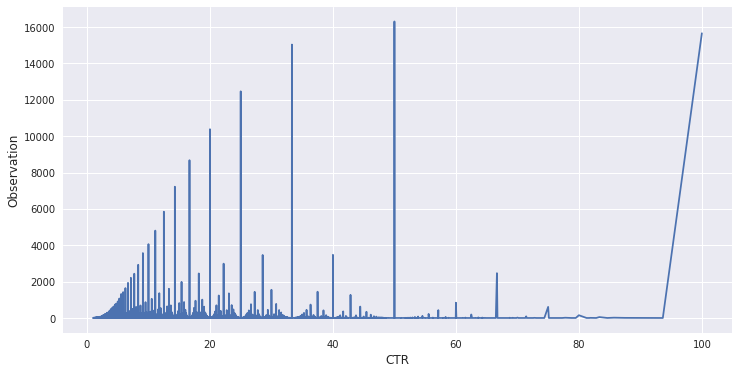

In [75]:
# plotting
train_ctr_notzero = train_ctr[1:] # except ctr=0 
print(len(train_ctr_notzero))

plt.figure(figsize=(12,6))
plt.plot(train_ctr_notzero.index, train_ctr_notzero.values)
plt.xlabel('CTR', fontsize=12)
plt.ylabel('Observation', fontsize=12)
plt.show()